In [ ]:
using Pkg
cd("../")
Pkg.activate(".")
using Revise
using MediumRandomNotes
using PyPlot
using JLD
using Dates
using GLM
using DataFrames

# Visualization for linear example

In [2]:
function find_h(b,N)
    sqrt(2*b*N)/(b+1)
end

find_h (generic function with 1 method)

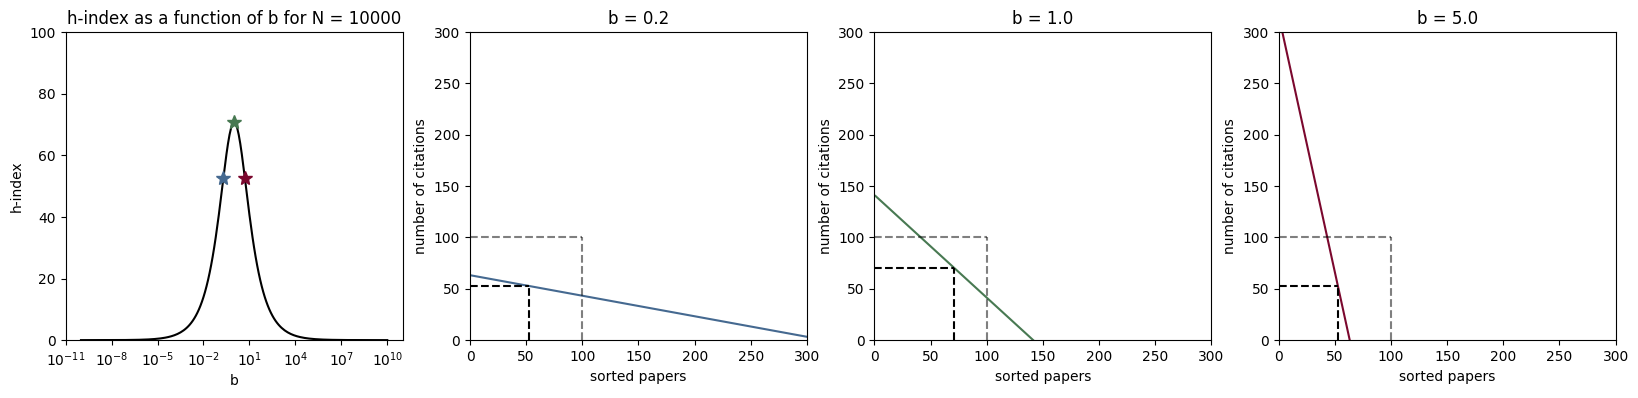

In [3]:
N = 10000
h_star = sqrt(N)
bs = 10. .^ (-10:0.1:10)
hs = find_h.(bs,N)
fig, axs = subplots(1, 4, figsize=(20, 4))

Colors = ["#456990","#487952","#7B082E"]
bs2 = [1/5, 1,5]

ax = axs[1]
ax.plot(bs,hs,"k")
ax.set_ylim([0,sqrt(N)])
#ax.set_xlim([0,1000])
for i =1:3
    ax.plot(bs2[i],find_h(bs2[i],N),"*",color = Colors[i],markersize=10)
end
ax.set_xlabel("b")
ax.set_ylabel("h-index")
ax.set_xscale("log")
ax.set_title("h-index as a function of b for N = 10000")

for i =1:3
    b = bs2[i]
    a = sqrt(2*b*N)
    h = find_h(b,N)
    x = 1:1000
    y = a .- b .* x
    ax = axs[1+i]
    ax.plot(x,y,color = Colors[i])
    ax.set_ylim([0,300])
    ax.set_xlim([0,300])
    ax.plot([0,h],[h,h],"--k")
    ax.plot([h,h],[0,h],"--k")
    ax.plot([0,h_star],[h_star,h_star],"--k",alpha = 0.5)
    ax.plot([h_star,h_star],[0,h_star],"--k",alpha = 0.5)
    ax.set_xlabel("sorted papers")
    ax.set_ylabel("number of citations")
    ax.set_title("b = " * string(round(b,digits=2)))
end


# Data analysis part

In [4]:
Rs_CN = load("src/Google_scholar_data/Fieldcomputational_neuroscience_Npage50_Date2021-03-16.jld")["Rs"];
Rs_ML =load("src/Google_scholar_data/Fieldmachine_learning_Npage50_Date2021-03-16.jld")["Rs"];
Rs_Ph = load("src/Google_scholar_data/Fieldhigh_energy_physics_Npage50_Date2021-03-16.jld")["Rs"];
Rs_tot = cat(Rs_CN,Rs_ML,Rs_Ph,dims=1);

In [5]:
Titles = ["Computational Neuroscience","Machine Learning","High Energy Physics"]
Rs_s = [Rs_CN,Rs_ML,Rs_Ph]
linearRegressor_s = []
for i = 1:3
    println("------------------------------------------------")
    println("------------------------------------------------")
    println("------------------------------------------------")
    println(Titles[i])
    println("------------------------------------------------")
    println("------------------------------------------------")
    println("------------------------------------------------")
    df = DataFrame(logN = log.(access_N_cite.(Rs_s[i])), logH = log.(access_h_index.(Rs_s[i])));
    @show linearRegressor = lm(@formula(logH ~ logN), df);
    @show r2(linearRegressor);
    push!(linearRegressor_s, linearRegressor)
    println("")
    println("")
end

------------------------------------------------
------------------------------------------------
------------------------------------------------
Computational Neuroscience
------------------------------------------------
------------------------------------------------
------------------------------------------------
linearRegressor = lm(#= In[5]:13 =# @formula(logH ~ logN), df) = StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

logH ~ 1 + logN

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  -0.647135   0.10494    -6.17    <1e-08  -0.853316  -0.440955
logN          0.47264    0.0122308  38.64    <1e-99   0.44861    0.496671
───────────────────────────────────

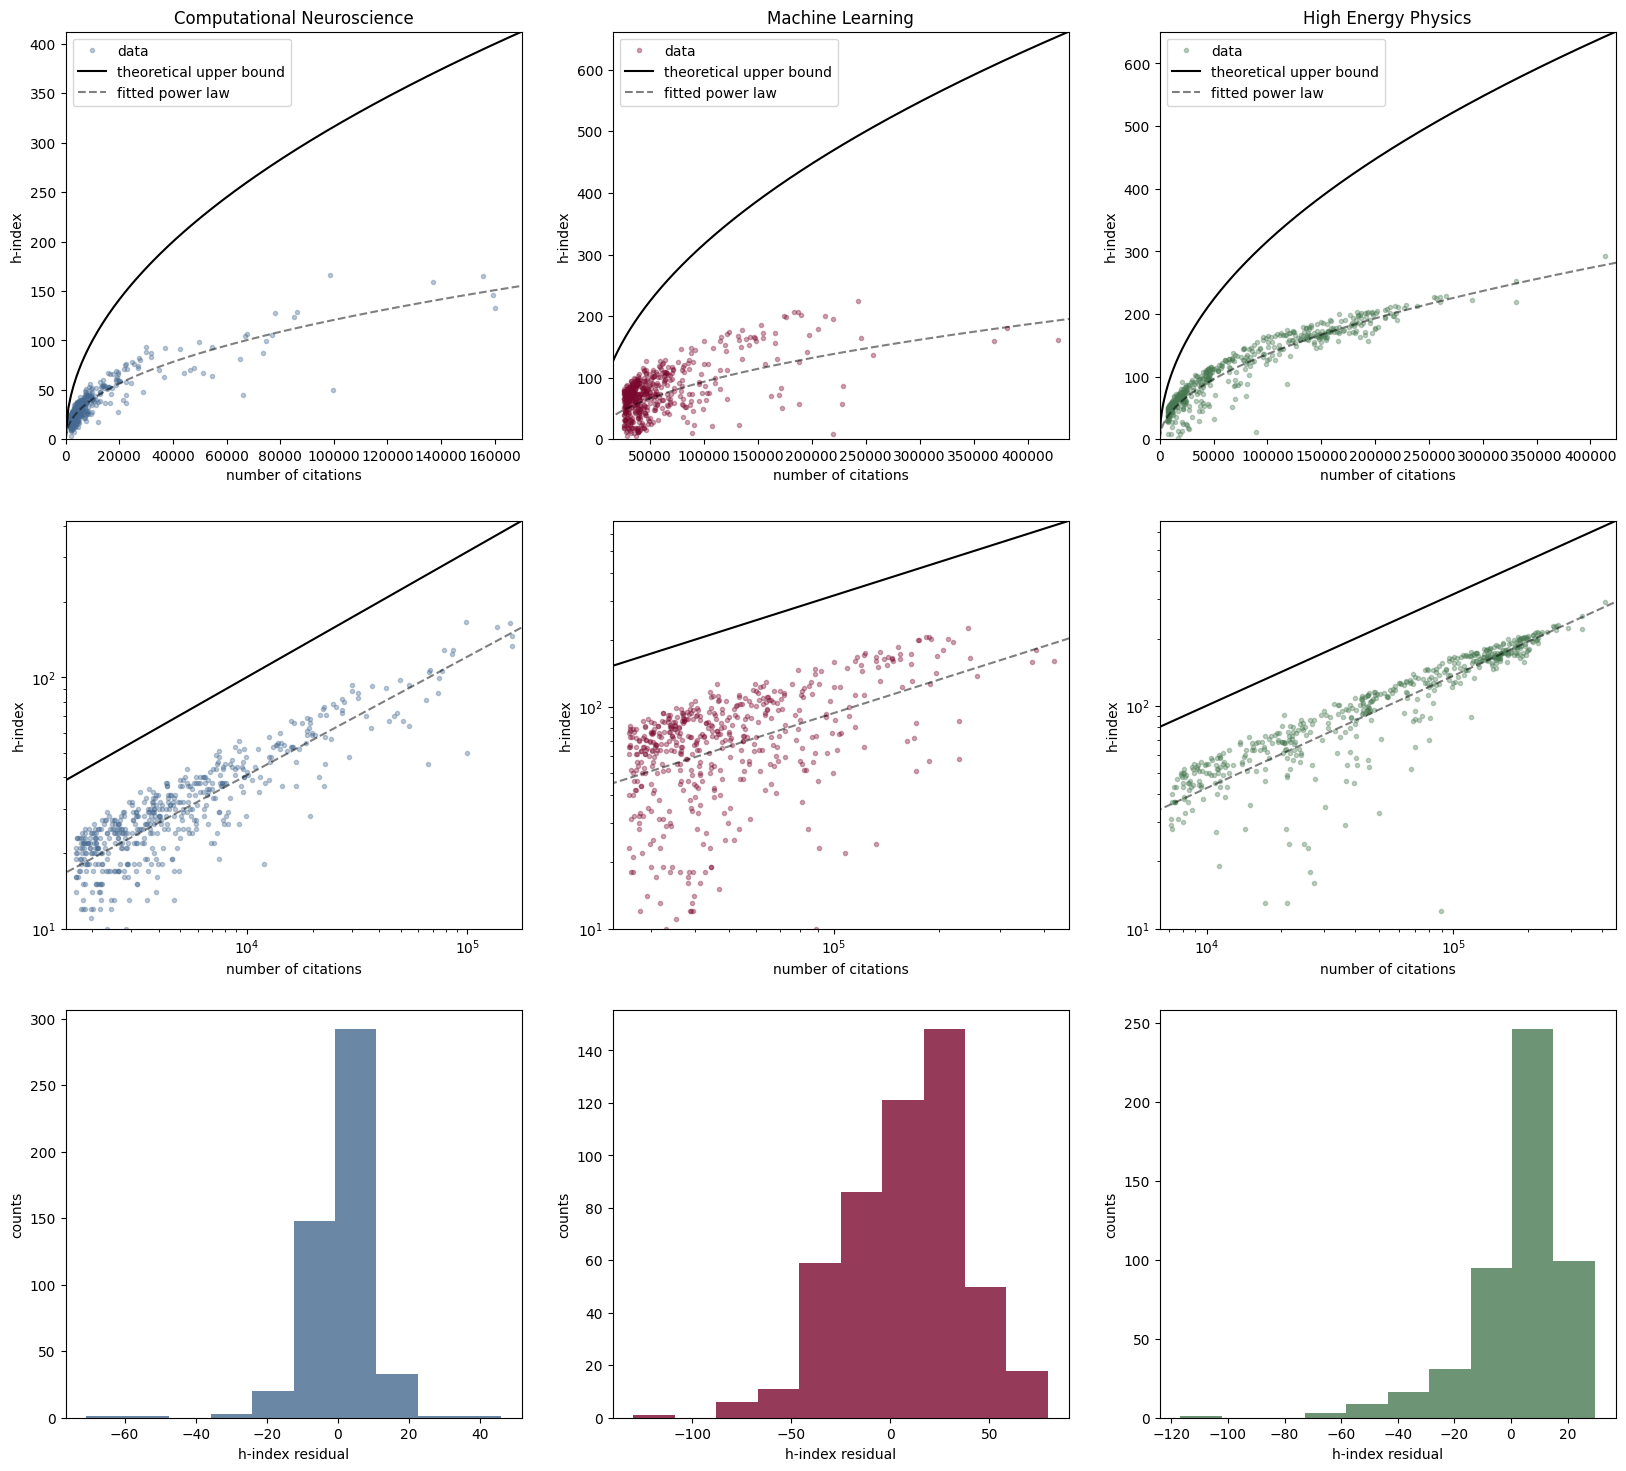

In [6]:
Colors = ["#456990","#7B082E","#487952"]
fig, axs = subplots(3, 3, figsize=(20, 18))
for i = 1:3
    x = 1:1000:(findmax(access_N_cite.(Rs_s[i]))[1]+100000)
    y_hat = exp(coef(linearRegressor_s[i])[1]) .* x.^(coef(linearRegressor_s[i])[2]) 
    ax = axs[(i-1)*3 + 1]
    ax.plot(access_N_cite.(Rs_s[i]),  access_h_index.(Rs_s[i]),".",color=Colors[i],alpha=0.35)
    ax.plot(x,  sqrt.(x),"k")
    ax.plot(x,  y_hat,"--k",alpha=0.5)
    ax.set_ylabel("h-index")
    ax.set_xlabel("number of citations")
    ax.set_title(Titles[i])
    ax.legend(["data","theoretical upper bound","fitted power law"])
    ax.set_xlim([max(0,findmin(access_N_cite.(Rs_s[i]))[1]-10000),findmax(access_N_cite.(Rs_s[i]))[1]+10000])
    ax.set_ylim([0,sqrt(findmax(access_N_cite.(Rs_s[i]))[1]+10000)])

    ax = axs[(i-1)*3 + 2]
    ax.plot(access_N_cite.(Rs_s[i]),  access_h_index.(Rs_s[i]),".",color=Colors[i],alpha=0.35)
    ax.plot(x,  sqrt.(x),"k")
    ax.plot(x,  y_hat,"--k",alpha=0.5)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel("h-index")
    ax.set_xlabel("number of citations")
    ax.set_xlim([max(1,findmin(access_N_cite.(Rs_s[i]))[1]*0.9),findmax(access_N_cite.(Rs_s[i]))[1]*1.1])
    ax.set_ylim([10,sqrt(findmax(access_N_cite.(Rs_s[i]))[1]*1.1)])
    
    ax = axs[(i-1)*3 + 3]
    ax.hist(access_h_index.(Rs_s[i])  .- exp.(predict(linearRegressor_s[i])),color=Colors[i],alpha=0.8)
    ax.set_xlabel("h-index residual")
    ax.set_ylabel("counts")
end    
